In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy.random import Generator, PCG64

# Error computation on the distributions

In the first part of this lecture we will continue the topic of the error on the distributions trying to understand how we can compute the error between the analytical solution given by the Fokker-Plank equation and the distribution obtain with the simulations. We will also try to develop some possible ways to simulate in a more automated way the local behaviour representation and the representation of the error.

For this task we will use the already studied **harvest process** for which we know all the conditions on the parameters and the bifurcations. We rembember that the problem equation was:

$$
\frac{dx}{dt}=a_0\left(x(1-x)\right)-kx+s(x(1-x))\xi(t)
$$

For comodity we will consider a situation in which $k/a_0<1$. For $s$ the integrability value is $s<\sqrt{2(a_0-k)}$ so we do not have a fixed hard bound but considering the worst and best case we have that, given the condition on $k/a_0$, $0\leq s\leq\sqrt{2}$. For the singular cases we will consider a restricted zone.

For the Fokker-Plank equation, we can solve the equation finding that the not normalized solution is equal to 

$$
P_s(x)=A(1-x)^{-\frac{2(a_0+s^2-k)}{s^2}}x^{-\frac{2(-a_0+s^2+k)}{s^2}}e^{\frac{2k}{s^2(x-1)}}
$$

Obviously the problem here is that we need some ways to obtain the normalization constant. This is too complex to integrate and obtain a general form to compute the normalization constant so we will need to integrate it numerically each time in its domain ( that is $[0,1)$) to compute it.

## Step 1

So we need to implement a method that allow us to compute the normalization value in the domain given $a_0,s,k$. We can simply then compute the integral using the trapezoidal rule (or other means if you like) and the normalization constant will be the inverse of this value. For this first tests we will use $a_0=1.0$, $k=0.3$ and $s=0.25$. We are also passing the domain's limits: we will see then the reason.

In [2]:
def compute_norm_cost(a0: float,k: float,s: float,N: int,omega_l:float,omega_t: float)->float:
    '''
    Given the three parameters, this function will compute the normalization
    constant of the analytical distribution using the trapezoidal rule in N steps
    '''

    #Introduce the formula of the analytical distribution
    P_s = lambda x: (1-x)**(-(2*(a0+s**2-k))/s**2)*x**(-(2*(-a0+s**2+k))/s**2)*np.exp(2*k/(s**2*(x-1)))

    #Define the grid and the step
    y = np.linspace(omega_l,omega_t,N+1)
    h = 1.0/N

    #Initialize integral
    I = 0.0

    #We need to stop at N-1 because the last point is equal to 1.0 and it's not defined for this value.
    for i in range(N-1):
        I += h*(P_s(y[i])+P_s(y[i+1]))/2

    return 1.0/I

In [3]:
compute_norm_cost(1.0,0.3,0.25,1000,0,1)

177647.28981397636

## Step 2

Prepared all the pieces necessaries to obtain the analytical distribution we can move to the simulative part. We can start importing the code from the previous notebooks to produce the distributions.

In [4]:
#THE CLASS

class Harvest(object):
    '''
    This function will simulate trajectories for an initialize
    perturbed logistic system
    '''
    def __init__(self,a0: float,k: float,s:float)->None:
        self.a0 = a0
        self.k = k
        self.s = s

        if(a0<=0 or k<=0 or s<=0):
            raise RuntimeError("One of the given parameter is 0 or negative")
        
        return

    def __checkInputs(self,x0: float,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if x0<0:
            raise RuntimeError("Initial population must be positive")

        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the PLS
        '''
        self.__checkInputs(y_n,t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: self.a0*x*(1-x)-self.k*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the PLS.
        '''
        self.__checkInputs(x0,T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) 
            dx += self.s*traj[i-1]*(1.0-traj[i-1])*rng.normal()*np.sqrt(h) 
            traj[i] = traj[i-1] + dx
            if traj[i]<0: traj[i]=0.0

        return traj,time

In [5]:
#THE PRODUCTION CODE

omega = [0.0,1.0] 
Nbins = 250 
Nsim = 5000
m = (omega[1]-omega[0])/Nbins
system = Harvest(1.0,0.3,0.25)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


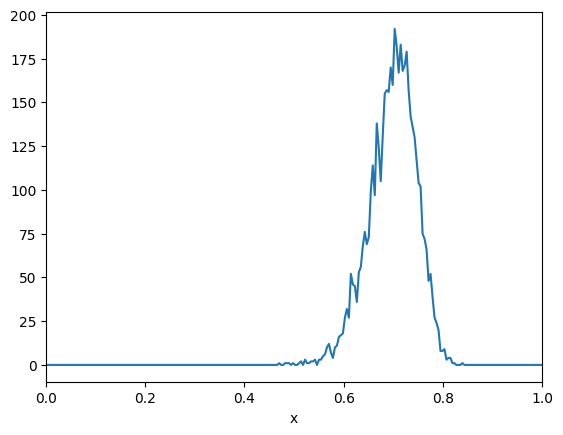

In [6]:
#THE PLOT

x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(0.0,1.0)
plt.plot(x,bins)

We have applied no normalization on the dataset so we need to normalize it to be able to confront the results with the analytical solution. We can simply normalize dividing for N_sim*m

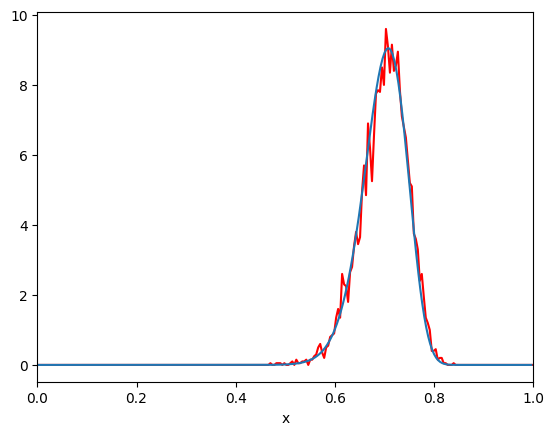

In [7]:
#Transforming the bins
t_bins = bins/(Nsim*m)

#Computing the analytical solution
P_s = lambda x,a0,k,s: (1-x)**(-(2*(a0+s**2-k))/s**2)*x**(-(2*(-a0+s**2+k))/s**2)*np.exp(2*k/(s**2*(x-1)))
y = np.linspace(0,1,251)
y = y[0:-1]
A = compute_norm_cost(1.0,0.3,0.25,1000,0,1)

#Plot
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(0.0,1.0)
plt.plot(x,t_bins,color="r")
plt.plot(y,A*P_s(y,1.0,0.3,0.25))

As we can observe we have that the analytical distribution and the simulative one have a good match.

## Step 3

Ok now we need to compute the distance between the two distributions. There are a lot of ways but in this case we will use the **Kullback-Leiber distance or divergence**. This is a quantification of the distance between two distributions. It has not an absolut meaning beside from the 0 case in which we have no error so it can be used only under a comparison point of view. In our case having distributions such the one above where the two almost coincide give us some paragons.  

The Kullback-Leiber divergence given two distributions $P(x)$ and $Q(x)$ is

$$
D_{KL}(P||Q)=\sum_i P(i)\log_2\left(\frac{P(i)}{Q(i)}\right)
$$

Some important observations:

- Firstly, the KL is not a symmetric distance so doing $D_{KL}(Q||P)$ will produce different results. For this reason is important to keep the role of the two distributions.
- Secondly, the $Q(x)$ has a further hypothesis which is that $Q(x)>0$ $\forall x$. So 0 values are not admitted for this distribution.

For this reason, in our case the only possible solution will be to use as $P(x)$ the bins and as $Q(x)$ the analytical one.

To do a small double check we can print the values for the analytical distribution.

In [8]:
A*P_s(y,1.0,0.3,0.25)

array([0.00000000e+000, 1.54199740e-048, 2.26391280e-042, 9.39552703e-039,
       3.52782063e-036, 3.55092058e-034, 1.55433048e-032, 3.82998740e-031,
       6.19735983e-030, 7.27320240e-029, 6.62551290e-028, 4.91704835e-027,
       3.08104566e-026, 1.67488333e-025, 8.06721484e-025, 3.50087469e-024,
       1.38738491e-023, 5.07659582e-023, 1.73088955e-022, 5.54126997e-022,
       1.67649718e-021, 4.82001706e-021, 1.32315335e-020, 3.48237743e-020,
       8.81871358e-020, 2.15559358e-019, 5.09997573e-019, 1.17079112e-018,
       2.61369197e-018, 5.68520507e-018, 1.20703766e-017, 2.50535453e-017,
       5.09115220e-017, 1.01421154e-016, 1.98300020e-016, 3.80951687e-016,
       7.19782439e-016, 1.33879018e-015, 2.45339616e-015, 4.43304609e-015,
       7.90362170e-015, 1.39131750e-014, 2.41973940e-014, 4.16006719e-014,
       7.07377933e-014, 1.19024534e-013, 1.98269292e-013, 3.27111306e-013,
       5.34726873e-013, 8.66421256e-013, 1.39200576e-012, 2.21826156e-012,
       3.50736247e-012, 5

As we can observe there are small values near the tails that reach the 0 values. We can opt for two possible solutions:

- Do a correction to all of those points transforming them in some values near 0
- Do not consider all the case in which the analytical solution is 0.

Both of the solutions have some pros and cons. However we can try to think a bit upon the second solution which seems the easier under the coding POV. We can do some considerations:

- Given the fact that we will stay in the parametrical condition for which our analytical distribution is valid we have that the behaviours of the two should not be too much different so we can expect to have the same critical points
- If we have not the same critical points we can expect that the attractiveness of a critical point will be overevaluated in the simulation and for this reason another one disappear. So the number of the critical points of the simulations should be lesser or equal than the number of critical points of the analytical solution.

For these reasons we can imagine that in the areas where the analytical solutions tends to 0 (the antimodes) we should have that the simulations should have almost 0 values and all the problems on the error should appear on the attractive critical points (both value differences and the absence of an attractor point for the simulations) and in their neighborhood. So we can opt for the second solution and do not count the 0 values situations for the analytical distribution.


So let's prepare a method to compute this distance. We have also to remember to adjust the case in which $P[i]=0$ manually to have no problem with the computations. Actually, we can join the case of $P[i]=0$ and $Q[i]=0$ because in the first case we have to manually sum 0 and in the second we need to skip that element on the sum but, at the end, the contribution is the same.

In [9]:
def kullback_leiber(P: np.array,Q: np.array)->float:
    '''
    This function will compute the Kullback-Leiber distance between
    the distributions P and Q. P should be the simulative distribution
    while Q the analytical one
    '''

    #First we have to check that the array have the same length
    if(len(P)!=len(Q)):
        raise RuntimeError("The length of the arrays of the two distributions must be the same")

    DKL = 0.0

    for i in range(len(P)):
        if(P[i]>0.0 and Q[i]>0.0):
            DKL += P[i]*np.log2(P[i]/Q[i])

    return DKL

In [10]:
print(len(t_bins),len(y))

kullback_leiber(t_bins,A*P_s(y,1.0,0.3,0.25))

250 250


3.8850299489313587

Ok we gathered all the pieces to proceed on our analysis. As said, this value for the KL has no meaning per se and we need to compare the value with the others. Obviously doing again and again the computation will not produce the same results due to stochastic contributions to the trajcetories and the distributions.

## Step 4

Now we can start to analyse the error for the different configurations. We have that the value of $k$ and $a_0$ are not actually dependant in their absolut value but the only important thing is their ratio $k/a_0$ so we can simply fix $a_0=1.0$ and change $k$. We have suppose that $0\leq k/a_0\leq 1$ so we will have the same domain for $k$ only. For $s$ we have seen that the meaningful value can change so we will consider the whole domain so $0\leq s< \sqrt{2}$. 

With these observations upon the domain of the parameter space we can define a 2D grid. I will consider 50 points for each axis and to avoid possible problems at the limit of our domain we will start not from 0 and we will not arrive to exactly the upper limit. This is needed because at the divergence point, even if the value is integrable we cannot have in the simulation an infinite high peak so the error will be infinity in this point. 

A similar problem happens when we have too small fluctuations in fact exists a certain value in which case we will have no more a finite peak but an infinite one. If you do some tests you will find that it's around $0.10-0.15$ for low $k$s but it has some kind of dependance from $k$ that makes it smaller with k growing. This case is no so easily eliminable without doing internal checks in the integral and KL methods so we will simply exclude this cases from our analysis starting from an $s_{base}=0.15$ 

In [11]:
#CREATION OF THE GRID FOR THE PARAMETERS'SPACE

N = 10

delta_k = 1/N
delta_s = (np.sqrt(2)-0.15)/N

k_grid = np.zeros(N,dtype=float)
s_grid = np.zeros(N,dtype=float)

for i in range(N):
    k_grid[i] = (i+0.5)*delta_k
    s_grid[i] = (i+0.5)*delta_s+0.15

print(k_grid)
print(s_grid)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0.21321068 0.33963203 0.46605339 0.59247475 0.7188961  0.84531746
 0.97173882 1.09816017 1.22458153 1.35100288]


In [12]:
#PRODUCTION CODE

#SET SIMULATIONS CHARACTERISTICS
omega = [0.01,0.99] 
Nbins = 250 
Nsim = 2500
m = (omega[1]-omega[0])/Nbins

#SET DOMAIN AND CHARACTERISTICS FOR THE ANALYTIC SOLUTION
y = np.linspace(omega[0],omega[1],Nbins+1)
y = y[0:-1]
P_s = lambda x,a0,k,s: (1-x)**(-(2*(a0+s**2-k))/s**2)*x**(-(2*(-a0+s**2+k))/s**2)*np.exp(2*k/(s**2*(x-1)))

#SET THE ERROR MATRIX
err = np.zeros((len(k_grid),len(s_grid)),dtype=float)

for k in range(len(k_grid)):
    for j in range(len(s_grid)):
        if(s_grid[j]**2<2*(1.0-k_grid[k])):
            system = Harvest(1.0,k_grid[k],s_grid[j])
            
            rng_0 = Generator(PCG64())
            
            bins = np.zeros(Nbins,dtype=float)
            
            for _ in range(Nsim):
                ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
                for i in range(Nbins):
                    if ptraj[-1] < (m*(i+1)+omega[0]):
                        bins[i] += 1.0
                        break

            t_bins = bins/(Nsim*m)
            A = compute_norm_cost(1.0,k_grid[k],s_grid[j],1000,omega[0],omega[1])

            err[k,j]=kullback_leiber(t_bins,A*P_s(y,1.0,k_grid[k],s_grid[j]))

C:\Users\loren\AppData\Local\Temp\ipykernel_21952\918668956.py:9: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(s_grid,k_grid,np.log(err),cmap='plasma')


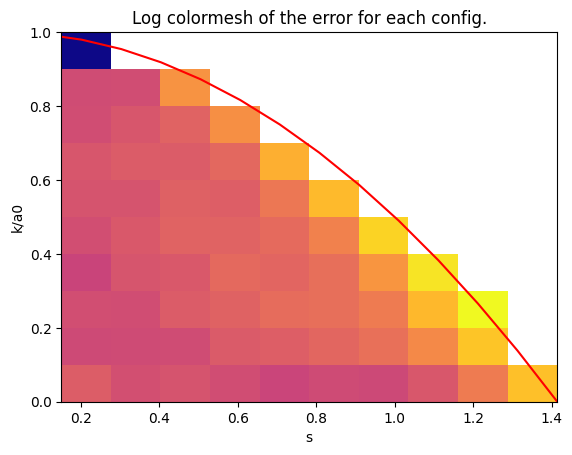

In [13]:
x=np.linspace(0,10,100)

plt.plot(x,(1-x**2/2),color='r')
plt.title("Log colormesh of the error for each config.")
plt.xlabel("s")
plt.ylabel("k/a0")
plt.xlim(min(s_grid-delta_s/2),max(s_grid+delta_s/2))
plt.ylim(min(k_grid-delta_k/2),max(k_grid+delta_k/2))
plt.pcolormesh(s_grid,k_grid,np.log(err),cmap='plasma')

The red line is a delimitation marker for the integrable region.
We can make some observations looking at this graphical representation:

1. Firstly we can think a bit about the errors we are finding. Considering our cut upon the domain we can firmly say that the upper left blue square is probably wrong. In fact for that value we should have our attractor point located in $0.95$+something due to the $s$ (do you remember what happens when you grow with $s$ to the upper stable point?). With the domain truncation, most of our points of interest are probably outside in this case.
2. Anyway, for the other points we have obtained good results. If you like, you can also use library such as Seaborn to print the value of each cell upon it to have an improve readability. Looking at the colormesh we can see that the error grows with bigger fluctuations (it makes sense) and grows with greater $k$. In this way know where our simulation can move away from the solutions.
3. An indirect gain obtainable with this computation is, modifying the code a bit, that we can save in some variables all of these distributions and in such way produce, using an automated codes, all the plots. With all the plots obtained we can also create a mega-plot similar to the colormesh above but with the plot distribution in each cell. This mega-plot will allow us to see rapidly the differences moving along the parameters.